In [19]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from utils import plot_decision_regions, plot_linear_equation

In [111]:
from batchup import data_source

In [20]:
iris = datasets.load_iris()
X = iris["data"][:100, [0, 2]]  # type: ignore # Sepal length and Petal length
y = iris["target"][:100]  # type: ignore

In [21]:
class Perceptron:
    def __init__(self, eta=0.1, n_iter=20, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        self._w = rng.normal(loc=0, scale=0.01, size=X.shape[1])
        self._b = np.zeros(1)
        self._errors = list()
        self._w_list = list()
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self._w += update * xi
                self._b += update
                if update != 0.0:
                    errors += int(update != 0.0)
                    self._w_list.append(
                        [float(self._w[0]), float(self._w[1]), float(self._b)]
                    )
            self._errors.append(errors)
        return self

    def predict(self, X):
        return np.where(self.linear(X) <= 0, 0, 1)

    def linear(self, X):
        return np.dot(X, self._w) + self._b

/var/folders/1k/j3wyh39j0ydf13qfn63_c7440000gn/T/ipykernel_50477/397535787.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors += int(update != 0.0)
/var/folders/1k/j3wyh39j0ydf13qfn63_c7440000gn/T/ipykernel_50477/397535787.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [float(self._w[0]), float(self._w[1]), float(self._b)]


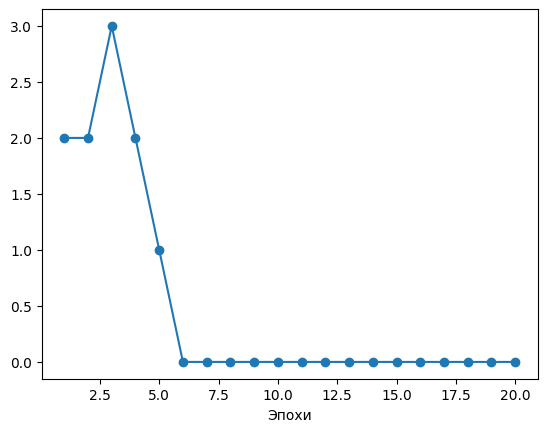

In [23]:
ppn = Perceptron().fit(X, y)
plt.plot(range(1, len(ppn._errors)+1), ppn._errors, marker='o')
plt.xlabel("Эпохи")
plt.show()

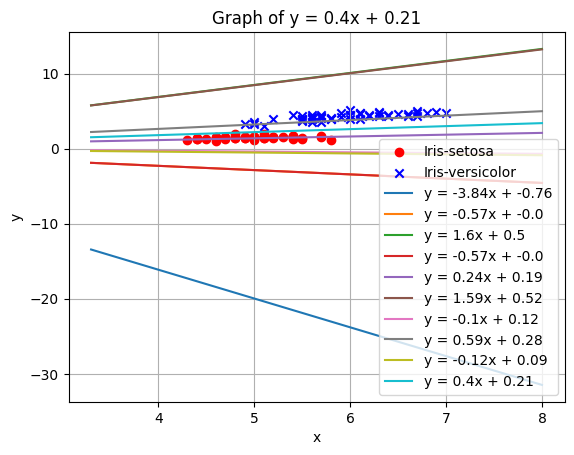

In [24]:
# print(ppn._w_list)
plot_linear_equation(X, y, ppn._w_list)

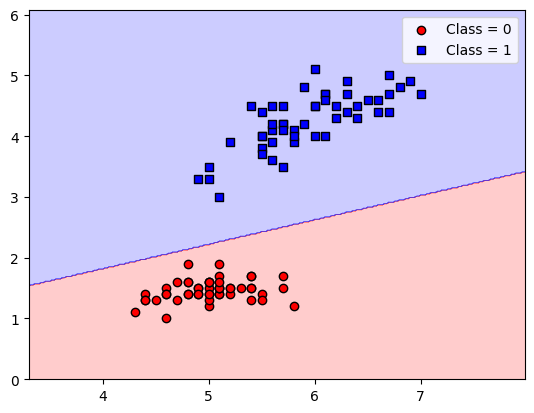

In [17]:
plot_decision_regions(X, y, ppn)

In [103]:
class AdalineGd:
    def __init__(self, eta=0.1, n_iter=20, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        self._w = rng.normal(loc=0, scale=0.01, size=X.shape[1])
        self._b = np.zeros(1)
        self._losses = list()
        
        for _ in range(self.n_iter):

            net_input = self.linear(X)
            output = self.activation(net_input)
            errors = (y - output)
            self._w += 2.0 * self.eta * X.T.dot(errors)/X.shape[0]
            self._b += 2.0 * self.eta * errors.mean()
            loss = (errors**2).mean()
            self._losses.append(loss)
        #print(X.T.shape, errors.shape, self._w.shape)
        return self

    def predict(self, X):
        return np.where(self.activation(self.linear(X)) <= 0.5, 0, 1)
    def activation(self, X):
        return X

    def linear(self, X):
        return np.dot(X, self._w) + self._b

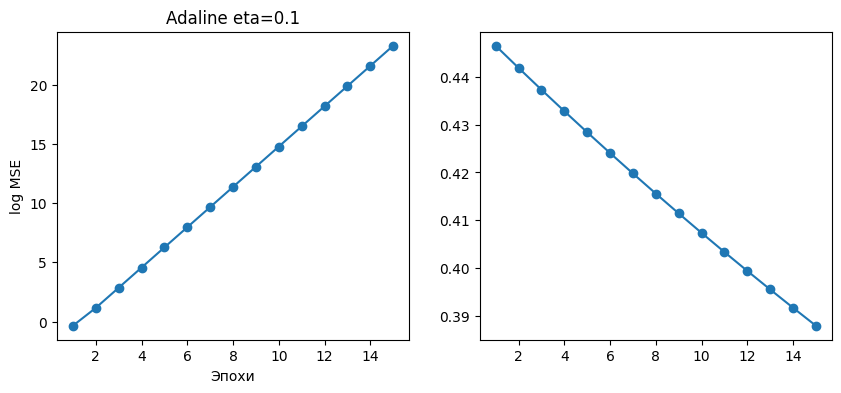

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
ada1 = AdalineGd(n_iter=15, eta=0.1).fit(X, y)
ada2 = AdalineGd(n_iter=15, eta=0.0001).fit(X, y)
ax[0].plot(range(1, len(ada1._losses) + 1), np.log10(ada1._losses), marker='o')
ax[0].set_xlabel("Эпохи")
ax[0].set_ylabel("log MSE")
ax[0].set_title("Adaline eta=0.1")
ax[1].plot(range(1, len(ada2._losses) + 1), ada2._losses, marker='o')

In [77]:
X_std = X.copy()
X_std = (X - X.mean(axis=0))/X.std(axis=0)

In [83]:
ada_std = AdalineGd(n_iter=20, eta=0.5).fit(X_std, y)

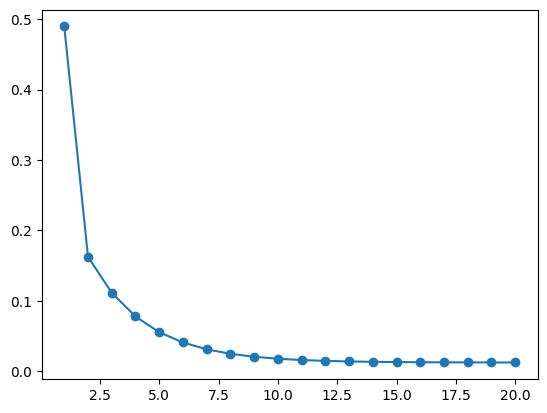

In [84]:
plt.plot(range(1, len(ada_std._losses) + 1), ada_std._losses, marker='o')

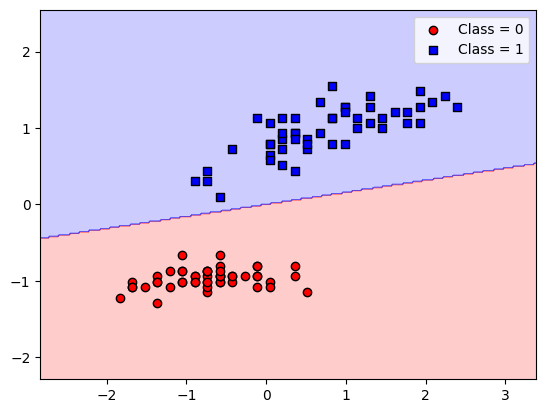

In [85]:
plot_decision_regions(X_std, y, ada_std)

In [104]:
class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=20, shuffle=True, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.shuffle = shuffle
        self.w_initialized = False

    def fit(self, X, y):
        self._losses = list()
        self.initialize_weight(X.shape[1])
        
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weight(xi, target))
            avg_loss = np.mean(losses)          
            self._losses.append(avg_loss)
        #print(X.T.shape, errors.shape, self._w.shape)
        return self
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self.initialize_weight(X.shape[1])
        if len(y) > 1:
            for xi, target in zip(X, y):
                self._update_weight(xi, target)
        else:
            self._update_weight(X, y)

        return self
    def _update_weight(self, X, y):
         net_input = self.linear(X)
         output = self.activation(net_input)
         errors = (y - output)
         self._w += 2.0 * self.eta * X * errors
         self._b += 2.0 * self.eta * errors
         loss = errors**2
         return loss

    def _shuffle(self, X, y):
        r = self.rng.permutation(len(y))
        return X[r], y[r]
        
    def initialize_weight(self, m):
        self.rng = np.random.default_rng(self.random_state)
        self._w = self.rng.normal(loc=0, scale=0.01, size=m)
        self._b = np.zeros(1)
        self.w_initialized = True

    def predict(self, X):
        return np.where(self.activation(self.linear(X)) <= 0.5, 0, 1)
    def activation(self, X):
        return X

    def linear(self, X):
        return np.dot(X, self._w) + self._b

In [108]:
ada_std = AdalineSGD(n_iter=20, eta=0.01).fit(X_std, y)

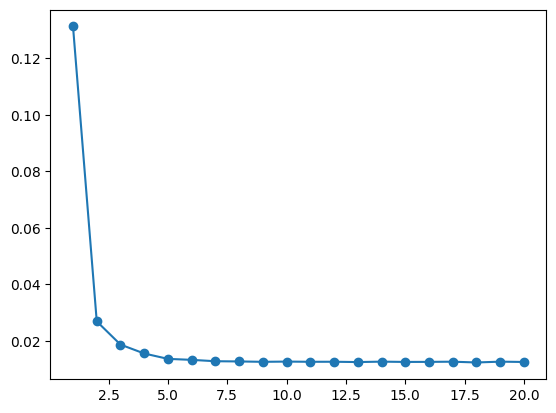

In [109]:
plt.plot(range(1, len(ada_std._losses) + 1), ada_std._losses, marker='o')

In [112]:
ds = data_source.ArrayDataSource([X, y])

In [162]:
# for (batch_X, batch_y) in ds.batch_iterator(
#         batch_size=4, shuffle=np.random.RandomState(12345)):
#     print(batch_y)

In [115]:
class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=20, shuffle=True, batch_size=4, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.shuffle = shuffle
        self.w_initialized = False
        self.batch_size = batch_size

    def fit(self, X, y):
        self._losses = list()
        self.initialize_weight(X.shape[1])
        
        for _ in range(self.n_iter):
            losses = []
            ds = data_source.ArrayDataSource([X, y])
            for (batch_X, batch_y) in ds.batch_iterator(batch_size=self.batch_size):  
                losses.append(self._update_weight(batch_X, batch_y))
            avg_loss = np.mean(losses)          
            self._losses.append(avg_loss)
        #print(X.T.shape, errors.shape, self._w.shape)
        return self
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self.initialize_weight(X.shape[1])
        if len(y) >= self.batch_size:
            ds = data_source.ArrayDataSource([X, y])
            for (batch_X, batch_y) in ds.batch_iterator(batch_size=self.batch_size):
                self._update_weight(batch_X, batch_y)
        else:
            pass

        return self
    def _update_weight(self, X, y):
         net_input = self.linear(X)
         output = self.activation(net_input)
         errors = (y - output)
         self._w += 2.0 * self.eta * X.T.dot(errors)/X.shape[0]
         self._b += 2.0 * self.eta * errors.mean()
         loss = (errors**2).mean()
         return loss

    def _shuffle(self, X, y):
        r = self.rng.permutation(len(y))
        return X[r], y[r]
        
    def initialize_weight(self, m):
        self.rng = np.random.default_rng(self.random_state)
        self._w = self.rng.normal(loc=0, scale=0.01, size=m)
        self._b = np.zeros(1)
        self.w_initialized = True

    def predict(self, X):
        return np.where(self.activation(self.linear(X)) <= 0.5, 0, 1)
    def activation(self, X):
        return X

    def linear(self, X):
        return np.dot(X, self._w) + self._b

In [128]:
ada_std = AdalineSGD(n_iter=50, eta=0.01).fit(X_std, y)

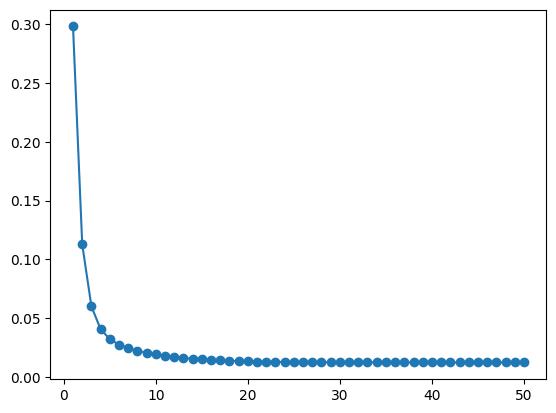

In [129]:
plt.plot(range(1, len(ada_std._losses) + 1), ada_std._losses, marker='o')

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [196]:
X = iris["data"][:, [2, 3]]  # type: ignore # Sepal length and Petal length
y = iris["target"]

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3, stratify=y) 

In [198]:
sc = StandardScaler()

In [199]:
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [200]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [201]:
y_pred = ppn.predict(X_test_std)
accuracy_score(y_test, y_pred)

0.9333333333333333

In [202]:
ppn.score(X_test_std, y_test)

0.9333333333333333

In [203]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ['o', 's', '^', 'v', '<']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl, 0], X[y==cl, 1], marker=markers[idx], c=colors[idx], label=f'Class = {cl}', edgecolors='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], 
                    marker='o', c='none', s=100,
                    edgecolors='black', linewidths=1,
                    label=f'Test set')

In [204]:
X_combined_std = np.vstack([X_train_std, X_test_std])
y_combined = np.hstack([y_train, y_test])

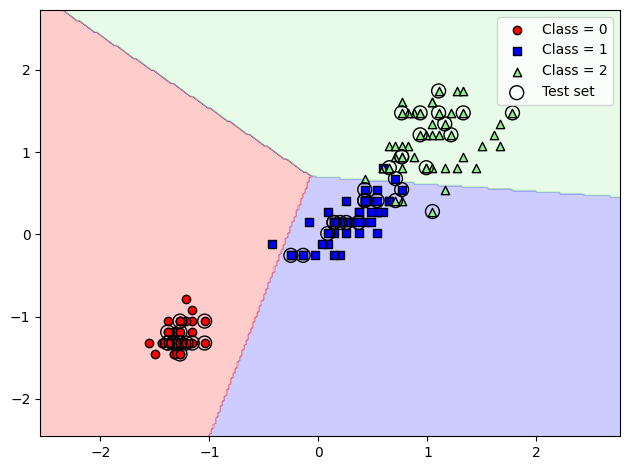

In [205]:
plot_decision_regions(X_combined_std, y_combined, ppn, test_idx=range(len(y_train), len(y)))
plt.legend()
plt.tight_layout()
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1k/j3wyh39j0ydf13qfn63_c7440000gn/T/ipykernel_50477/3321926771.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma(z)$')


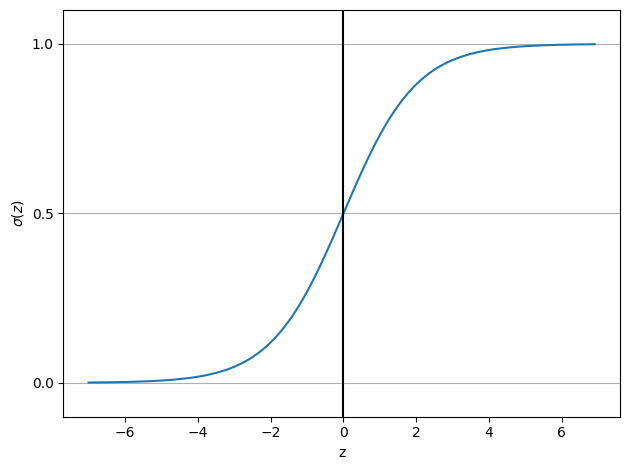

In [226]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
sig = sigmoid(z)
plt.plot(z, sig)
plt.axvline(0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.yticks([0, 0.5, 1])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show();

In [230]:
def los_1(z):
    return - np.log(sigmoid(z))
def los_0(z):
    return - np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1k/j3wyh39j0ydf13qfn63_c7440000gn/T/ipykernel_50477/2723850032.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(z)$')


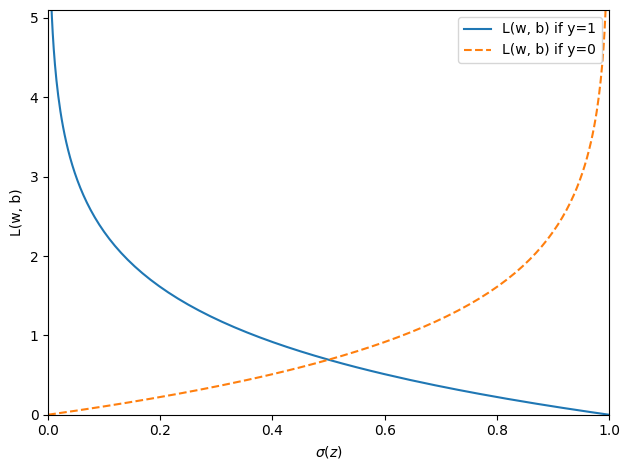

In [244]:
plt.plot(sigma_z, los_1(z), label='L(w, b) if y=1')
plt.plot(sigma_z, los_0(z), label='L(w, b) if y=0', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0.0, 5.1)
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [245]:
class LogisticReegressionGD:
    def __init__(self, eta=0.1, n_iter=20, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        self._w = rng.normal(loc=0, scale=0.01, size=X.shape[1])
        self._b = np.zeros(1)
        self._losses = list()
        
        for _ in range(self.n_iter):

            net_input = self.linear(X)
            output = self.activation(net_input)
            errors = (y - output)
            self._w += 2.0 * self.eta * X.T.dot(errors)/X.shape[0]
            self._b += 2.0 * self.eta * errors.mean()
            loss = (-y.dot(np.log(output)) - (1 - y).dot(1 - np.log(1 - output)))/X.shape[0]
            self._losses.append(loss)
        #print(X.T.shape, errors.shape, self._w.shape)
        return self

    def predict(self, X):
        return np.where(self.activation(self.linear(X)) <= 0.5, 0, 1)
    def activation(self, z):
        return 1./(1. + np.exp(-np.clip(z, -250, 250)))

    def linear(self, X):
        return np.dot(X, self._w) + self._b

In [249]:
X_train_01_sub = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_sub = y_train[(y_train == 0) | (y_train == 1)]

In [251]:
lrgd = LogisticReegressionGD(eta=0.3, n_iter=500, random_state=1)
lrgd.fit(X_train_01_sub, y_train_01_sub)

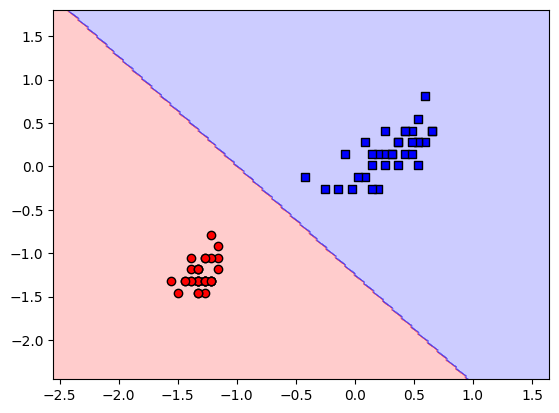

In [252]:
plot_decision_regions(X_train_01_sub, y_train_01_sub, lrgd)

In [256]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

/Users/fidailbirdigulov/Documents/homework/vscode/Learning_base/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=100, multi_class='ovr')

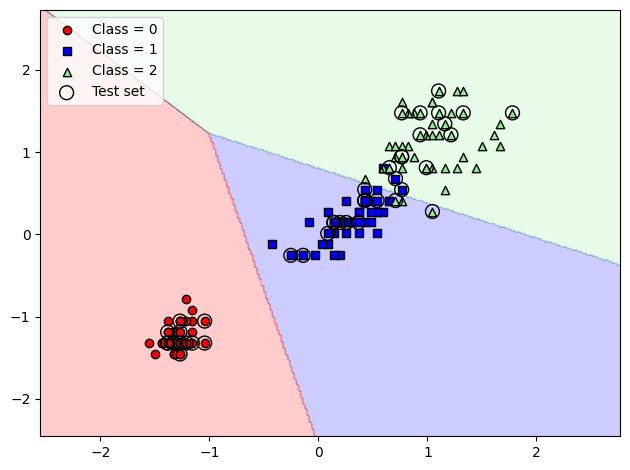

In [262]:
plot_decision_regions(X_combined_std, y_combined, lr, test_idx=range(105, 150))
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

In [265]:
lr.predict_proba(X_test_std[:3]).sum(axis=1)

array([1., 1., 1.])

In [266]:
lr.predict_proba(X_test_std[:3]).argmax(axis=1)

array([0, 2, 0])

In [267]:
lr.predict(X_test_std[:3])

array([0, 2, 0])

In [282]:
lr.predict(X_test_std[0][np.newaxis, :])

array([0])

In [281]:
X_test_std[0][np.newaxis, :].shape

(1, 2)

In [279]:
X_test_std[:3].shape

(3, 2)

In [285]:
lr.coef_

array([[-5.88013758, -4.76656664],
       [ 2.7964531 , -2.46388956],
       [ 7.4489719 ,  8.52201979]])